In [1]:
# Image processing and OCR
from PIL import Image, ImageDraw
import cv2
import pytesseract
from paddleocr import PaddleOCR, draw_ocr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


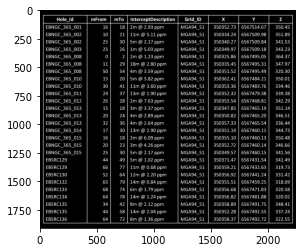

1010.0555555555555
[2112, 1876, 1610, 1344, 990, 694, 517, 222]
[2023/10/19 06:27:52] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\user/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\user/.paddleocr/whl\\rec\\en\\en_PP-OCRv4_rec_infer', rec_image_inverse=Tru

,0,1,2,3,4,5,6,7
0,Hole Id,mFrom,mTo,InterceptDescription,Grid ID,x,Y,Z


In [5]:
img_path='C:/Users/user/Documents/capstone/Test Dataset__2/132302/132302_31 Cropped Images/132302_31_table_1.png' 
img_path='C:/Users/user/Documents/capstone/Test Dataset__2/108156/108156_16 Cropped Images/108156_16_table_0.png'

img = cv2.imread(img_path, 0)
thresh, img_bin = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)
img_bin = 255 - img_bin

plotting = plt.imshow(img_bin, cmap='gray')
plt.show()

img_bin2 = 255-img
thresh1,img_bin_otsu = cv2.threshold(img_bin2,128,255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)


kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, np.array(img).shape[1]//150))
eroded_image = cv2.erode(img_bin_otsu, vertical_kernel, iterations=5)
vertical_lines = cv2.dilate(eroded_image, vertical_kernel, iterations=5)

hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (np.array(img).shape[1]//150, 1))
image_2 = cv2.erode(img_bin, hor_kernel, iterations=5)
horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=5)

vertical_horizontal_lines = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
vertical_horizontal_lines = cv2.erode(~vertical_horizontal_lines, kernel, iterations=3)

thresh, vertical_horizontal_lines = cv2.threshold(vertical_horizontal_lines,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
b_image = cv2.bitwise_not(cv2.bitwise_xor(img,vertical_horizontal_lines))

contours, hierarchy = cv2.findContours(vertical_horizontal_lines, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
boundingBoxes = [cv2.boundingRect(c) for c in contours]
(contours, boundingBoxes) = zip(*sorted(zip(contours, boundingBoxes),
key=lambda x:x[1][1]))

boxes = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    if (w<1000 and h<500):
        image = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        boxes.append([x,y,w,h])

rows=[]
columns=[]
heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]
mean = np.mean(heights)

columns.append(boxes[0])
previous=boxes[0]
for i in range(1,len(boxes)):
    if(boxes[i][1]<=previous[1]+mean/2):
        columns.append(boxes[i])
        previous=boxes[i]
        if(i==len(boxes)-1):
            rows.append(columns)
    else:
        rows.append(columns)
        columns=[]
        previous = boxes[i]
        columns.append(boxes[i])

total_cells=0
for i in range(len(rows)):
    if len(rows[i]) > total_cells:
        total_cells = len(rows[i])

center = [int(rows[i][j][0]+rows[i][j][2]/2) for j in range(len(rows[i])) if rows[0]]
print(center)
center=np.array(center)
center.sort()

boxes_list = []
for i in range(len(rows)):
    l=[]
    for k in range(total_cells):
        l.append([])
    for j in range(len(rows[i])):
        diff = abs(center-(rows[i][j][0]+rows[i][j][2]/4))
        minimum = min(diff)
        indexing = list(diff).index(minimum)
        l[indexing].append(rows[i][j])
    boxes_list.append(l)


dataframe_final = []
ocr = PaddleOCR(use_angle_cls=True, lang='en')

for i in range(len(boxes_list)):
    for j in range(len(boxes_list[i])):
        s = ''
        if len(boxes_list[i][j]) == 0:
            dataframe_final.append(' ')
        else:
            for k in range(len(boxes_list[i][j])):
                y, x, w, h = boxes_list[i][j][k][0], boxes_list[i][j][k][1], boxes_list[i][j][k][2], boxes_list[i][j][k][3]
                roi = b_image[x:x+h, y:y+w]
                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                border = cv2.copyMakeBorder(roi, 2, 2, 2, 2, cv2.BORDER_CONSTANT, value=[255, 255])
                resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                dilation = cv2.dilate(resizing, kernel, iterations=1)
                erosion = cv2.erode(dilation, kernel, iterations=2)
                results = ocr.ocr(erosion)
                out = ' '.join([result[1][0] for result in results[0]])
                s += " " + out

            dataframe_final.append(s)

arr = np.array(dataframe_final)

dataframe = pd.DataFrame(arr.reshape(len(rows), total_cells))
data = dataframe.style.set_properties(align="left")

dataframe